In [1]:
import pandas as pd
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import river.metrics as metrics
import river.stream as stream
import seaborn as sns

In [2]:
#!pip install deep-river
#!pip install prettytable
#!pip install tabulate

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from torch import nn, manual_seed
from IPython.display import clear_output
from collections import deque, Counter
from river import metrics, preprocessing, compose, stream
from deep_river import classification
from prettytable import PrettyTable
from colorama import Fore, Style, init
from tabulate import tabulate
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('C:/Users/GCU/Downloads/CICIoT2023.csv')

In [5]:
#df = df.sample(frac=0.1, random_state=42)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280985 entries, 0 to 280984
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    280985 non-null  float64
 1   Header_Length    280985 non-null  float64
 2   Protocol Type    280985 non-null  float64
 3   Duration         280985 non-null  float64
 4   Rate             280985 non-null  float64
 5   Srate            280985 non-null  float64
 6   fin_flag_number  280985 non-null  float64
 7   syn_flag_number  280985 non-null  float64
 8   rst_flag_number  280985 non-null  float64
 9   psh_flag_number  280985 non-null  float64
 10  ack_flag_number  280985 non-null  float64
 11  ack_count        280985 non-null  float64
 12  syn_count        280985 non-null  float64
 13  fin_count        280985 non-null  float64
 14  urg_count        280985 non-null  float64
 15  rst_count        280985 non-null  float64
 16  HTTP             280985 non-null  floa

In [7]:
df['label'] = df['label'].str.replace('DDoS-UDP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SynonymousIP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-UDP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-TCP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SYN_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-PSHACK_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-RSTFINFlood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SlowLoris', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ACK_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-HTTP_Flood', 'DDoS')

df['label'] = df['label'].str.replace('DoS-TCP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-UDP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-SYN_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-HTTP_Flood', 'DoS')

df['label'] = df['label'].str.replace('Recon-HostDiscovery', 'Recon')
df['label'] = df['label'].str.replace('Recon-OSScan', 'Recon')
df['label'] = df['label'].str.replace('VulnerabilityScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PortScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PingSweep', 'Recon')

df['label'] = df['label'].str.replace('XSS', 'Web-Based')
df['label'] = df['label'].str.replace('Uploading_Attack', 'Web-Based')
df['label'] = df['label'].str.replace('BrowserHijacking', 'Web-Based')
df['label'] = df['label'].str.replace('SqlInjection', 'Web-Based')
df['label'] = df['label'].str.replace('CommandInjection', 'Web-Based')
df['label'] = df['label'].str.replace('Backdoor_Malware', 'Web-Based')

df['label'] = df['label'].str.replace('DictionaryBruteForce', 'Brute_Force')

df['label'] = df['label'].str.replace('MITM-ArpSpoofing', 'Spoofing')
df['label'] = df['label'].str.replace('DNS_Spoofing', 'Spoofing')

df['label'] = df['label'].str.replace('Mirai-greip_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-greeth_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-udpplain', 'Mirai')

df['label'] = df['label'].str.replace('BenignTraffic', 'Normal')

In [8]:
print(df['label'].value_counts())

label
DDoS           175720
DoS             64530
Mirai           20828
Normal          11029
Spoofing         4898
Recon            3604
Web-Based         249
Brute_Force       127
Name: count, dtype: int64


In [9]:
# Creating a dictionary of Types
attacks = {'DDoS':0, 'DoS':1, 'Recon':2, 'Web-Based':3,
           'Brute_Force':4, 'Spoofing':5, 'Mirai':6, 'Normal':7}
df['label'] = df['label'].map(attacks)

In [11]:
# Set random seed for reproducibility
manual_seed(42)

# Split features and labels
X = df.drop(columns=['label'])
y = df['label']
X, y = shuffle(X, y, random_state=42)

# Offline Model

In [12]:
# Offline training setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

offline_model = RandomForestClassifier()
offline_model.fit(X_train, y_train)

RandomForestClassifier()

# Online Model

In [13]:
# Define RNN for online learning
class MyRNN(nn.Module):
    def __init__(self, n_features):
        super(MyRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=n_features, hidden_size=32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 8)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X, _ = self.rnn(X.unsqueeze(0))
        X = self.fc(X[:, -1, :])
        X = self.softmax(X)
        return X

In [14]:
# Initialize the online model pipeline
model_pipeline = preprocessing.StandardScaler() | classification.Classifier(
    module=MyRNN,
    n_features=X.shape[1],
    loss_fn='cross_entropy',
    optimizer_fn='adam'
)

In [15]:
# Real-time metrics setup for multi-class evaluation
metrics_dict = {
    'Accuracy': metrics.Accuracy(),
    'Precision': metrics.MacroPrecision(),  # Macro-average for multi-class
    'Recall': metrics.MacroRecall(),
    'F1-score': metrics.MacroF1()
}

In [16]:
# Lists for tracking metrics over time for visualization
accuracy_values, precision_values, recall_values, f1_values = [], [], [], []

In [17]:
# Buffer for recent prediction accuracy
accuracy_buffer_offline = deque(maxlen=100)
accuracy_buffer_online = deque(maxlen=100)

In [18]:
# Set accuracy threshold for triggering online model updates
accuracy_threshold = 0.9  # Define your acceptable threshold

In [19]:
# Real-time metrics visualization function
def plot_metrics():
    clear_output(wait=True)    
    plt.figure(figsize=(14, 8))    
    plt.plot(accuracy_values, label='Accuracy', color='blue', linestyle='--', alpha=0.7)        
    plt.plot(precision_values, label='Precision', color='green', linestyle='--', alpha=0.7)        
    plt.plot(recall_values, label='Recall', color='orange', linestyle='--', alpha=0.7)        
    plt.plot(f1_values, label='F1 Score', color='red', linestyle='--', alpha=0.7)        
    
    # Set title and labels
    plt.title('Real-Time Metrics for Hybrid Model')
    plt.xlabel('Number of Samples')
    plt.ylabel('Metric Value')
    
    # Add grid and legend
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(loc='best')
    
    # Show plot   
    plt.show()

In [20]:
# Helper function to update accuracy buffer
def update_accuracy_buffer(buffer, y_true, y_pred):
    buffer.append(int(y_true == y_pred))
    return sum(buffer) / len(buffer)

In [21]:
# Streaming the dataset
dataset = stream.iter_pandas(X, y)
num_samples = 0

In [22]:
# Initialize tracking variables
num_updates = 0
agreement_count = 0
confidence_scores = []
total_time = 0
degradation_instances = 0
hybrid_predictions = []

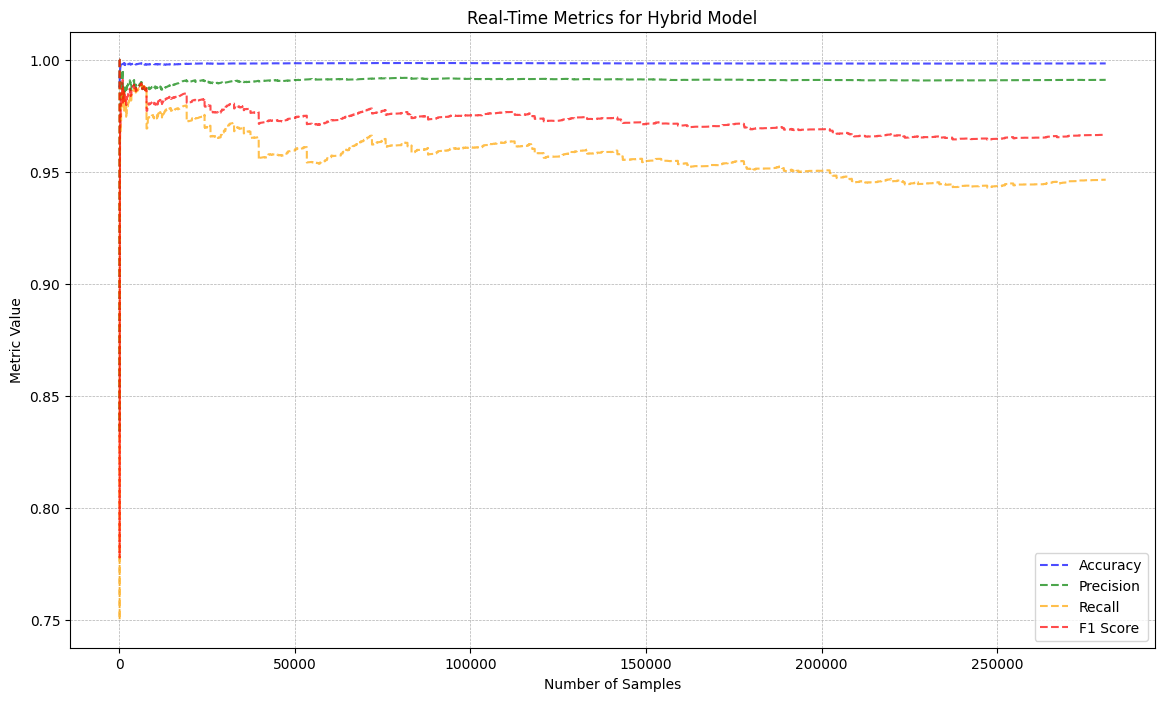

In [23]:
# Main loop for hybrid prediction
for x, y in dataset:
    start_time = time.time()  # Start time for runtime measurement
    
    num_samples += 1
    x_scaled = scaler.transform(pd.DataFrame([x]))  # Scale each streamed instance
    y_pred_offline = offline_model.predict(x_scaled)[0]
    y_pred_online = model_pipeline.predict_one(x)

    # Update accuracy buffers
    offline_accuracy = update_accuracy_buffer(accuracy_buffer_offline, y, y_pred_offline)
    online_accuracy = update_accuracy_buffer(accuracy_buffer_online, y, y_pred_online)

    # Decision logic: Select prediction from model with higher recent accuracy
    y_pred = y_pred_online if online_accuracy >= offline_accuracy else y_pred_offline

    # Check agreement between offline and online models
    if y_pred_offline == y_pred_online:
        agreement_count += 1

    # Append prediction to hybrid_predictions list
    hybrid_predictions.append(y_pred)

     # Calculate confidence score for online prediction, if available
    y_pred_online_prob = model_pipeline.predict_proba_one(x)
    confidence_score = max(y_pred_online_prob.values()) if y_pred_online_prob else None
    if confidence_score is not None:
        confidence_scores.append(confidence_score)

    # Update real-time metrics
    for name, metric in metrics_dict.items():
        metric.update(y, y_pred)
    
    # Append latest metrics for visualization
    accuracy_values.append(metrics_dict['Accuracy'].get())
    precision_values.append(metrics_dict['Precision'].get())
    recall_values.append(metrics_dict['Recall'].get())
    f1_values.append(metrics_dict['F1-score'].get())
   
    # Online model learning triggered by accuracy threshold
    if online_accuracy < accuracy_threshold:
        model_pipeline.learn_one(x, y)
        num_updates += 1
        degradation_instances += 1
           
    # Plot metrics every 50 samples
    if num_samples % 50 == 0:
        plot_metrics()

    # Runtime calculation
    end_time = time.time()
    total_time += (end_time - start_time)

In [24]:
# Final results after streaming
print("Final Performance Metrics of Hybrid Model:")
for name, metric in metrics_dict.items():
    print(f"{name}: {metric.get():.4f}")

Final Performance Metrics of Hybrid Model:
Accuracy: 0.9983
Precision: 0.9910
Recall: 0.9464
F1-score: 0.9665


In [25]:
# Print results
print(f"Processed samples: {num_samples}")
print(f"Sample {num_samples}: Prediction from {'Online' if y_pred == y_pred_online else 'Offline'} Model")
hybrid_pred_distribution = Counter(hybrid_predictions)
print(f"Hybrid Model Prediction Distribution: {dict(hybrid_pred_distribution)}")

Processed samples: 280985
Sample 280985: Prediction from Online Model
Hybrid Model Prediction Distribution: {1: 64526, 0: 175733, 5: 4874, 2: 3530, 6: 20829, 7: 11176, 3: 218, 4: 99}


In [26]:
print(f"Average Offline Model Accuracy: {offline_accuracy:.4f}")
print(f"Average Online Model Accuracy: {online_accuracy:.4f}")
print(f"Prediction Agreement Rate: {agreement_count / num_samples:.4f}")
if confidence_scores:
    avg_confidence = sum(confidence_scores) / len(confidence_scores)
    print(f"Average Online Model Confidence Score: {avg_confidence:.4f}")
recent_accuracy = sum(accuracy_buffer_online) / len(accuracy_buffer_online)
print(f"Recent Accuracy (last 100 samples): {recent_accuracy:.4f}")

Average Offline Model Accuracy: 1.0000
Average Online Model Accuracy: 0.8400
Prediction Agreement Rate: 0.8199
Average Online Model Confidence Score: 0.2725
Recent Accuracy (last 100 samples): 0.8400


In [27]:
print(f"Total Online Model Updates: {num_updates}")
print(f"Performance Degradation Instances: {degradation_instances}")

Total Online Model Updates: 256271
Performance Degradation Instances: 256271


In [28]:
print(f"Average Runtime per Sample: {total_time / num_samples:.4f} seconds")
throughput = num_samples / total_time
print(f"Throughput (samples per second): {throughput:.2f}")

Average Runtime per Sample: 0.0156 seconds
Throughput (samples per second): 63.92


In [29]:
print(f"Accuracy Threshold for Online Model Updates: {accuracy_threshold}")

Accuracy Threshold for Online Model Updates: 0.9


In [30]:
print("Decision Logic: Hybrid Prediction")
print(" - Prediction selected from the model with higher recent accuracy (last 100 samples).")
print(" - If offline and online predictions are equal, preference is given to the online model.")

Decision Logic: Hybrid Prediction
 - Prediction selected from the model with higher recent accuracy (last 100 samples).
 - If offline and online predictions are equal, preference is given to the online model.
